# Python notebook to plot apical region response to stimulation.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
To verify results incrementally, execute the code one block at a time using &lt;shift-return&gt;.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import numpy as np
import csv
import datetime
from skimage import io
from skimage import exposure
from skimage.util import img_as_float32
from skimage.morphology import binary_erosion
from skimage.morphology import binary_dilation
from skimage.morphology import label
from skimage.morphology import remove_small_objects

#### User editable parameters.
Take care with formatting!\
NOTE: The time-stamped results directory is created in this code block.

In [2]:
# editable user parameters

image_bits = 10          # bits per pixel (can be found in the oir meta data)
sample_period = 0.1      # sample time period in seconds

# stimulation frequency, file name
image_files = {
  1: "../image_stacks/Mistgcamp-3.tif",
  2: "../image_stacks/Mistgcamp-3_0001.tif",
  5: "../image_stacks/Mistgcamp-3_0002.tif",
  10: "../image_stacks/Mistgcamp-3_0003.tif"
}

roi_freq = 5             # simulation frequency to use for generating roi's
roi_quantile = 0.98      # roi threashold 

small_object = 16        # small object size to cull
dilations = 2            # number of dilations to apply

# create timestamp based results directory
if not os.path.exists("../results"):
  os.mkdir("../results")
resultsdir = "../results/" + str(datetime.datetime.now())[:-7]
resultsdir = resultsdir.replace('-', '').replace(' ', '-').replace(':','')
os.mkdir(resultsdir)


#### Get the image stack.


In [3]:
# get the image stack for roi's
A0 = io.imread(image_files[roi_freq])
A0 = np.float32(A0/(2.0**image_bits))

# average out y-direction aliasing over every other line
for n in range(A0.shape[0] - 1): # moving average over every two lines
  A0[n] = (A0[n] + A0[n+1]) / 2.0


#### Unstimulated average over time.


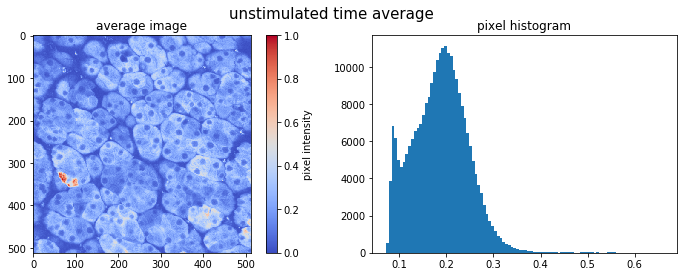

In [4]:
# unstimulated average over time
A = np.concatenate((A0[:100,:,:], A0[249:,:,:])) # unstimulated only
M = np.zeros(A[0].shape)
for n in range(A.shape[0]): # average over time
  M += A[n]
M /= A.shape[0]

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle("unstimulated time average", fontsize=15)

ax[0].imshow(M, norm=None, cmap='coolwarm') # image
ax[0].set_title("average image")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=1)
v = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(v, ax=ax[0], orientation='vertical', label='pixel intensity')

ax[1].hist(M.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/unstimulated_time_average.pdf")
plt.show()


#### Stimulated average over time.


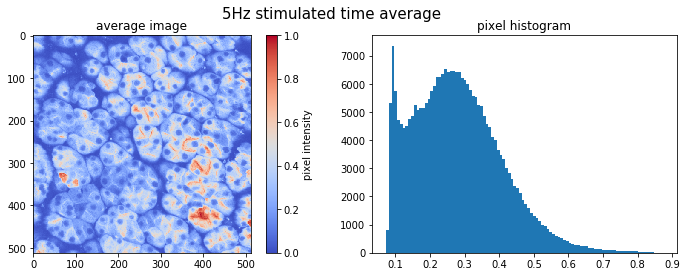

In [5]:
# stimulated average over time
A = A0[101:248,:,:] # stimulated only
N = np.zeros(A[0].shape)
for n in range(A.shape[0]): # average over time
  N += A[n]
N /= A.shape[0]

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle(str(roi_freq) + "Hz stimulated time average", fontsize=15)

ax[0].imshow(N, norm=None, cmap='coolwarm') # image
ax[0].set_title("average image")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=1)
v = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(v, ax=ax[0], orientation='vertical', label='pixel intensity')

ax[1].hist(N.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/stimulated_time_average.pdf")
plt.show()


#### Stimulated minus unstimulated average over time.


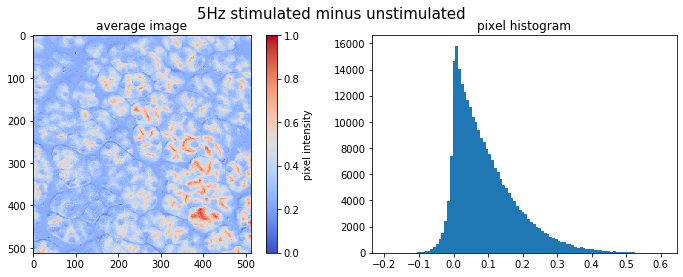

In [6]:
# difference: stimulated - unstimulated
O = N - M

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle(str(roi_freq) + "Hz stimulated minus unstimulated", fontsize=15)

ax[0].imshow(O, norm=None, cmap='coolwarm') # image
ax[0].set_title("average image")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=1)
v = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(v, ax=ax[0], orientation='vertical', label='pixel intensity')

ax[1].hist(O.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/stimulated_minus_unstimulated.pdf")
plt.show()


#### Create apical region-of-interest mask.


number of apical regions identified:  19
apical ROI values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
apical ROI pixel counts:  [140 137  72 291 189  66  65 303 142 267 216  54  61 111 888 247  87  58
  43]



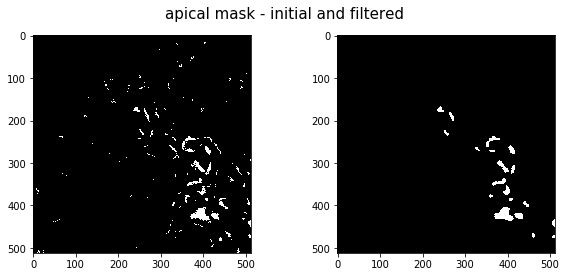

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle('apical mask - initial and filtered', fontsize=15)

# difference threashold filter
P = (O > np.quantile(O,roi_quantile)).astype(float)

# plot image
ax[0].imshow(P, norm=None, cmap='gray');
io.imsave(resultsdir + "/apical_mask_initial.tif", np.int16(P), check_contrast=False)

# filtering: erosion, remove small, then dilation
Q = binary_erosion(P)
Q = remove_small_objects(Q, small_object)
for i in range(dilations):
  Q = binary_dilation(Q)

ax[1].imshow(Q, norm=None, cmap='gray') # plot image
io.imsave(resultsdir + "/apical_mask_filtered.tif", np.int16(Q), check_contrast=False)

# label and get pixel counts
Q, n = label(Q, return_num=True)
io.imsave(resultsdir + "/apical_mask_labelled.tif", np.int16(Q), check_contrast=False)
ROI, COUNT = np.unique(Q, return_counts=True)
print("number of apical regions identified: ", ROI.shape[0]-1)
print("apical ROI values: ", ROI[1:])
print("apical ROI pixel counts: ", COUNT[1:])
print()


#### Plot apical region responses to stimulus.


*********************************************************************
 plots for ../image_stacks/Mistgcamp-3_0002.tif  (5Hz stimulation)
*********************************************************************

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 

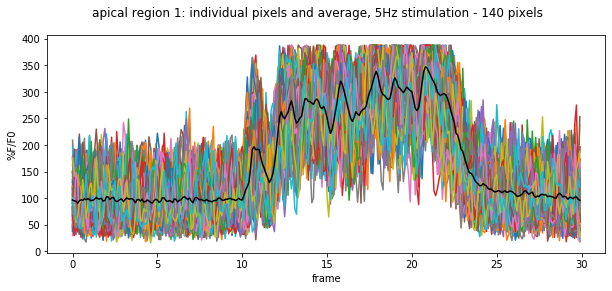

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

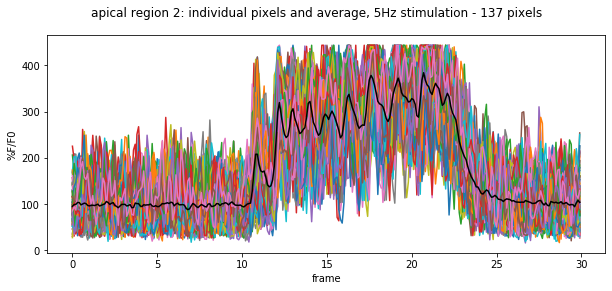

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

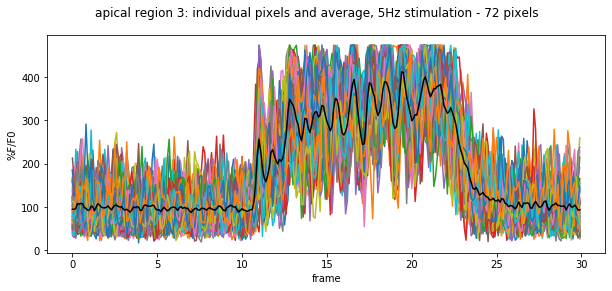

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

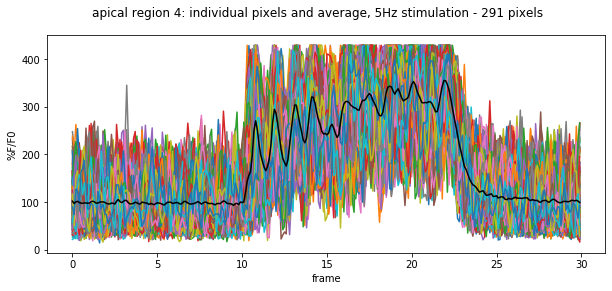

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

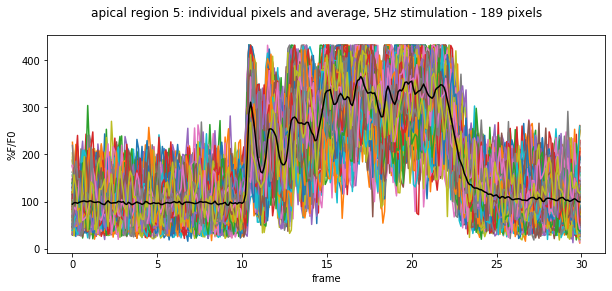

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

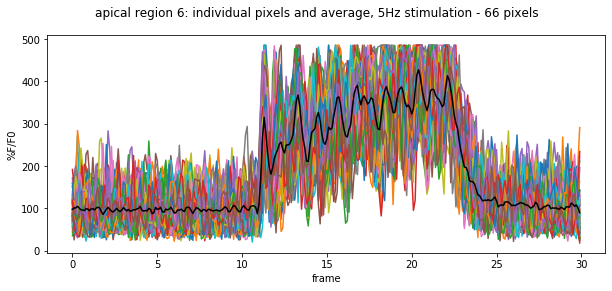

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

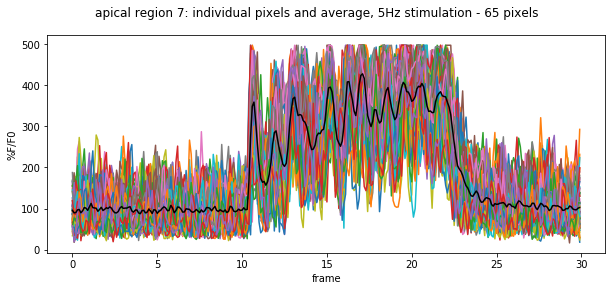

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

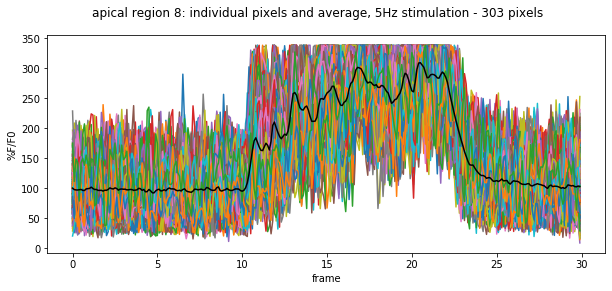

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

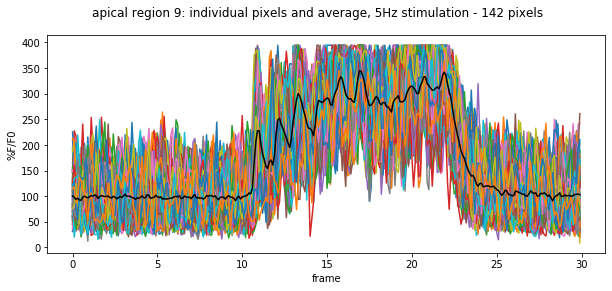

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

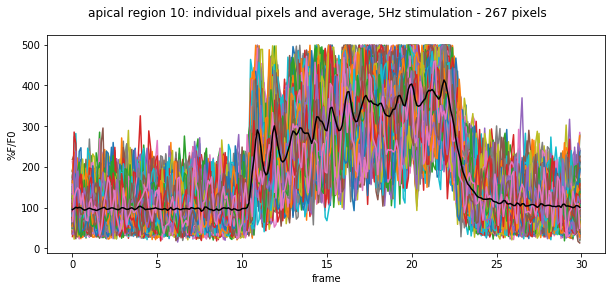

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

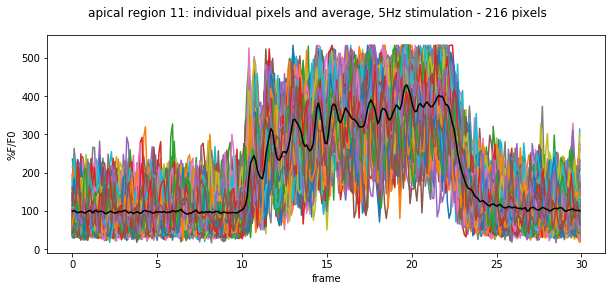

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

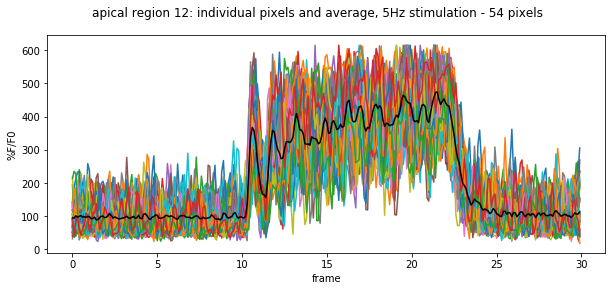

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

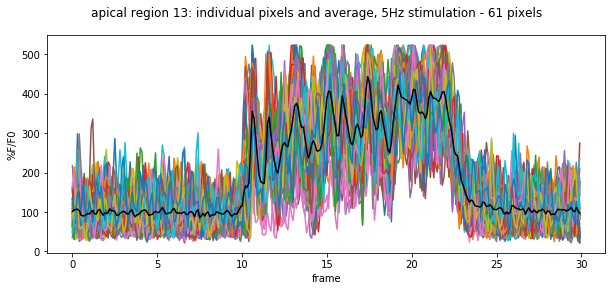

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

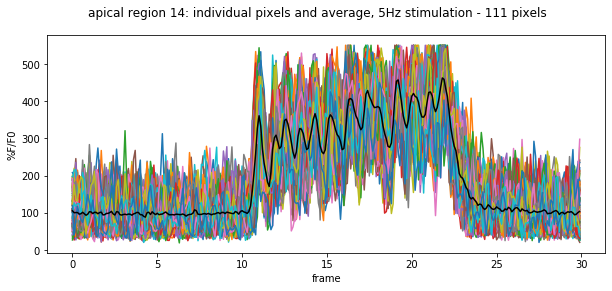

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

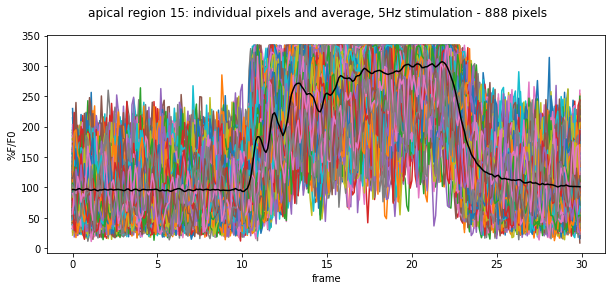

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

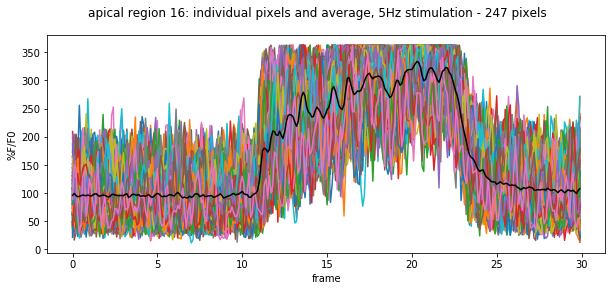

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

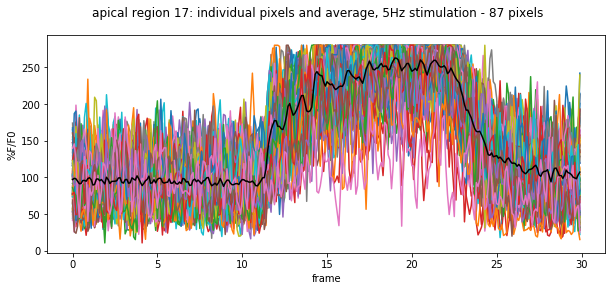

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

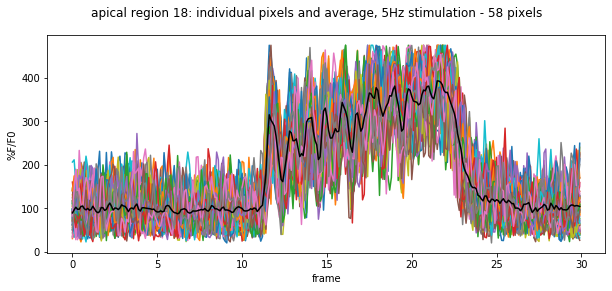

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

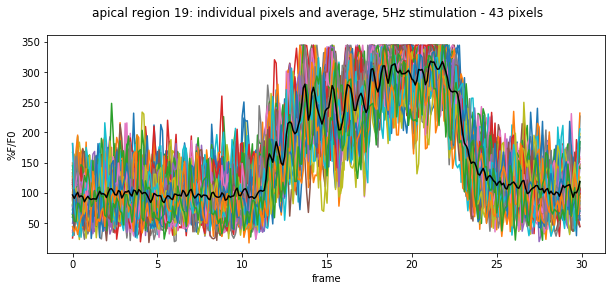

In [20]:
# apical region plots

print("*********************************************************************")
print(" plots for " + image_files[roi_freq] + "  (" + str(roi_freq) + "Hz stimulation)")
print("*********************************************************************")
print()

os.system("rm " + resultsdir + "/apical_region*.pdf") # delete any exiting region pdf's

X = np.array(range(A0.shape[0])) * sample_period

with open (resultsdir + "/apical_regions.csv", 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["'REGION'", "'DATA'"])

  # create and save plots
  for c in ROI:
    if(c==0):
      continue
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
    fig.suptitle('apical region ' + str(c)+ ": individual pixels and average, " + str(roi_freq) + "Hz stimulation - " +str(COUNT[c]) + " pixels")

    F0 = np.average(M[Q==ROI[c]]) # per region 
    #F0 = M[Q==ROI[c]] # per pixel
    S = 100 * A0[:, Q==ROI[c]] / F0
    T = np.sum(S, axis=1) / S.shape[1]
    ax.plot(X, S)
    ax.plot(X, T, color='black')
    ax.set(ylabel="%F/F0")
    ax.set(xlabel="time (s)")

    # save figure to pdf
    fig.savefig(resultsdir + "/apical_region_" + str(c) + ".pdf")
    
    # save region number and average plot data to csv
    t = np.concatenate((np.array([float(c)]), T)) # pre-pend the region number
    #t = np.array2string(t, separator=',', formatter={'float_kind':lambda x: '"%.2e"' % x})
    writer.writerow('{:3.3e}'.format(x) for x in t)

    plt.show()
    plt.close() # frees up memory